In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from gurobipy import *
from itertools import combinations
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10,10]

In [2]:
def Fin_data(date1,date2):
    df = pd.read_csv("sp500_stocks.csv")
    data = df.pivot(index='Date', columns='Symbol', values='Adj Close')
    data.index = pd.to_datetime(data.index)
    data = data[np.multiply(data.index>=date1, data.index<=date2)]
    return data

In [3]:
df = pd.read_csv("sp500_stocks.csv")
companies = df['Symbol'].unique()

In [4]:
def corr_mat(data, method):
    corr_matrix = data.corr(method=method)
    return corr_matrix

In [5]:
def weight_matrix(corr,theta):
    edge_weights = corr[corr>=theta].fillna(-2)
    return edge_weights

In [6]:
def stock_corr_net(edge_weights):
    G_sub = nx.Graph()
    for i in list(edge_weights.index):
        for j in list(edge_weights.index):
            if j!=i and edge_weights[i][j]>-1:
                G_sub.add_edge(i,j, weight=edge_weights[i][j])
    return G_sub

In [7]:
F_data = Fin_data('2020-04-01', '2022-10-31')
F_data.shape
# Size of our data

(652, 503)

In [8]:
company_info = pd.read_csv("sp500_companies.csv")
company_info = company_info[['Symbol', 'Sector','Industry']]

In [9]:
A = set(companies)
B = set(company_info['Symbol'])
C = list(A.intersection(B))

In [10]:
F_data = F_data[C]

df_new = F_data.isnull().sum()
missing_comp = []
mod_comp = []
for i in C:
    if df_new[i]>0:
        missing_comp.append(i)
        #print(i)
    else:
        mod_comp.append(i)

F_data = F_data[mod_comp]

In [11]:
# Calculating daily log return based on the closing price
for i in mod_comp:
    F_data[i] = np.log(F_data[i]/F_data[i].shift(1))

In [12]:
F_data = F_data.drop('2020-04-01')

In [13]:
colors = ['red', 'blue', 'yellow', 'green', 'orange', 'magenta', 'cyan', 'black', 'pink', 'purple', 'gray']
sector_list = list(np.unique(list(company_info['Sector'])))
sect_dict = {}
for i in range(company_info.shape[0]):
    sect_dict[company_info['Symbol'][i]] = colors[sector_list.index(company_info['Sector'][i])]
    # print(i)  
sect_dict['ELV'] = colors[sector_list.index('Healthcare')]
sect_dict['GEN'] = colors[sector_list.index('Real Estate')]
sect_dict['META'] = colors[sector_list.index('Technology')]
sect_dict['PARA'] = colors[sector_list.index('Consumer Cyclical')]
sect_dict['SBUX'] = colors[sector_list.index('Consumer Cyclical')]
sect_dict['V'] = colors[sector_list.index('Financial Services')]
sect_dict['WTW'] = colors[sector_list.index('Technology')]
sect_dict['WBD'] = colors[sector_list.index('Consumer Cyclical')]

In [14]:
corr_org = corr_mat(F_data,'pearson')
W_edge_org = weight_matrix(corr_org,-1)
H = stock_corr_net(W_edge_org)

corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,0.9)
G = stock_corr_net(W_edge)

In [15]:
c_map = []
for node in G:
    c_map.append(sect_dict[node])   

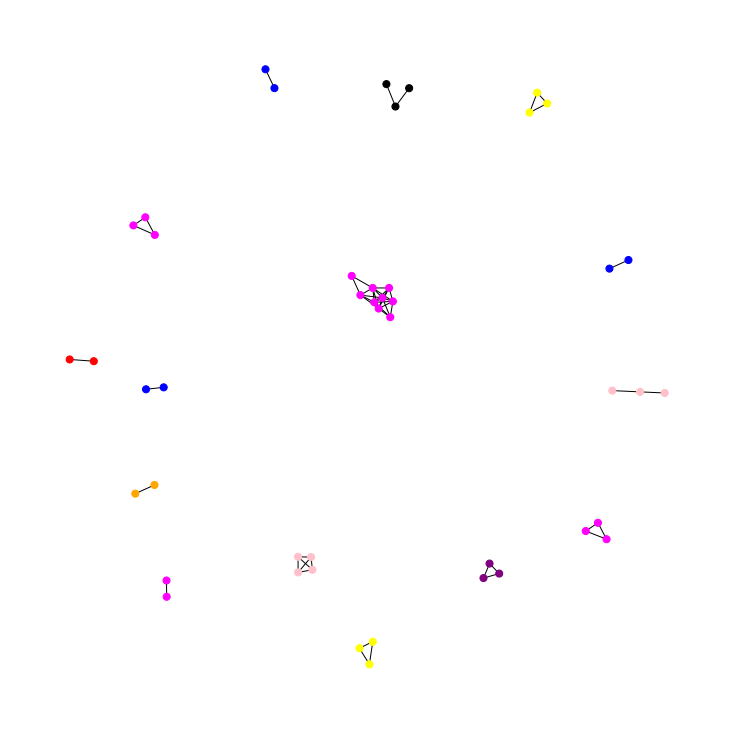

In [16]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

In [17]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-20
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 979 rows, 46 columns and 1958 nonzeros
Model fingerprint: 0x38b62da6
Variable types: 0 continuous, 46 integer (46 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -3.0000000
Presolve removed 931 rows and 15 columns
Presolve time: 0.02s
Presolved: 48 rows, 31 columns, 480 nonzeros
Variable types: 0 continuous, 31 integer (31 binary)

Root relaxation: objective -6.000000e+00, 11 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0           

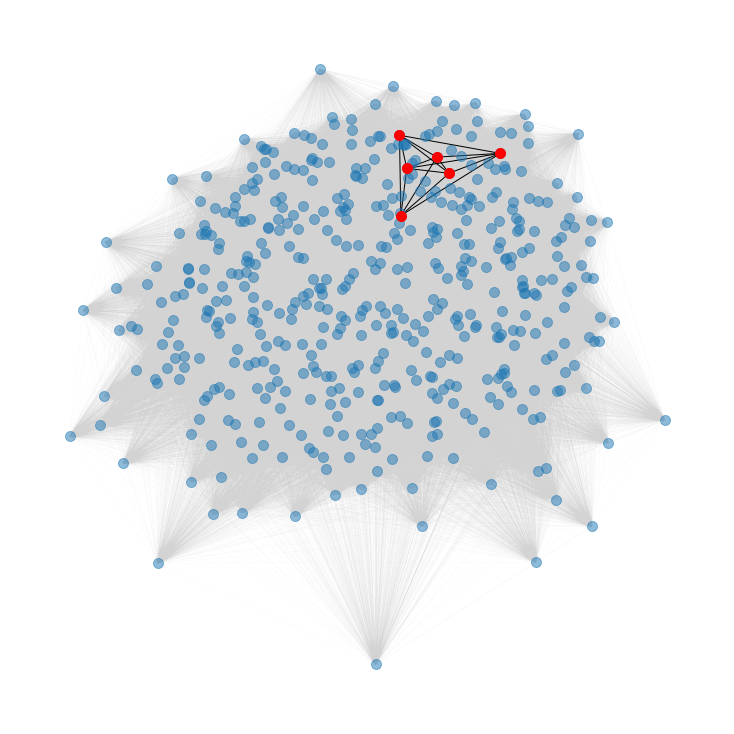

In [18]:
clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=100, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=100)

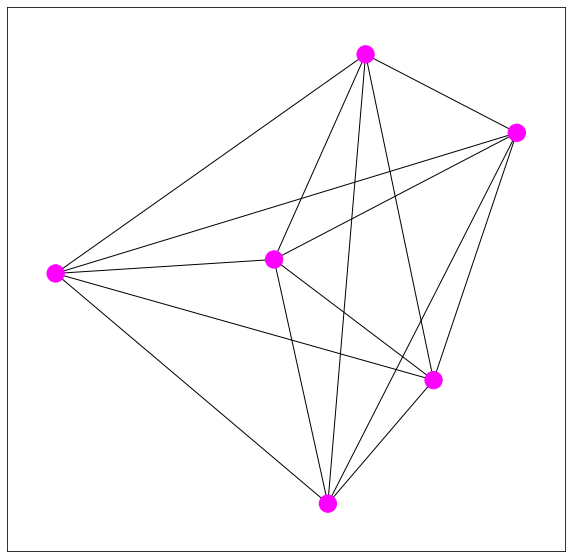

In [19]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

In [20]:
corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,0.8)
G = stock_corr_net(W_edge)

c_map = []
for node in G:
    c_map.append(sect_dict[node])   

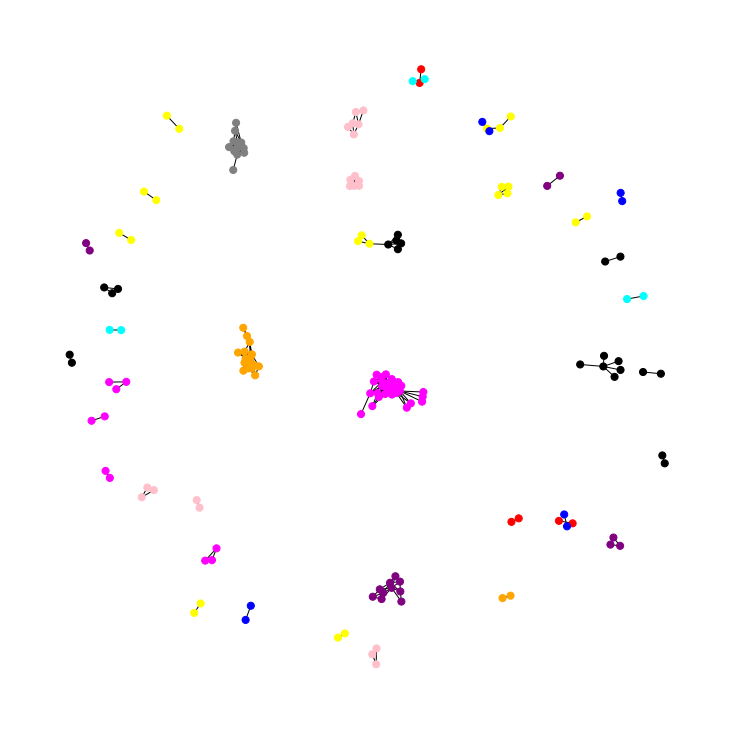

In [21]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 14937 rows, 176 columns and 29874 nonzeros
Model fingerprint: 0x0da71bcd
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -4.0000000
Presolve removed 14616 rows and 6 columns
Presolve time: 0.11s
Presolved: 321 rows, 170 columns, 14859 nonzeros
Variable types: 0 continuous, 170 integer (170 binary)

Root relaxation: objective -1.500000e+01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -15.0000000  -15.00000  0.00%     -    0s

Explored 1 nodes (28 simp

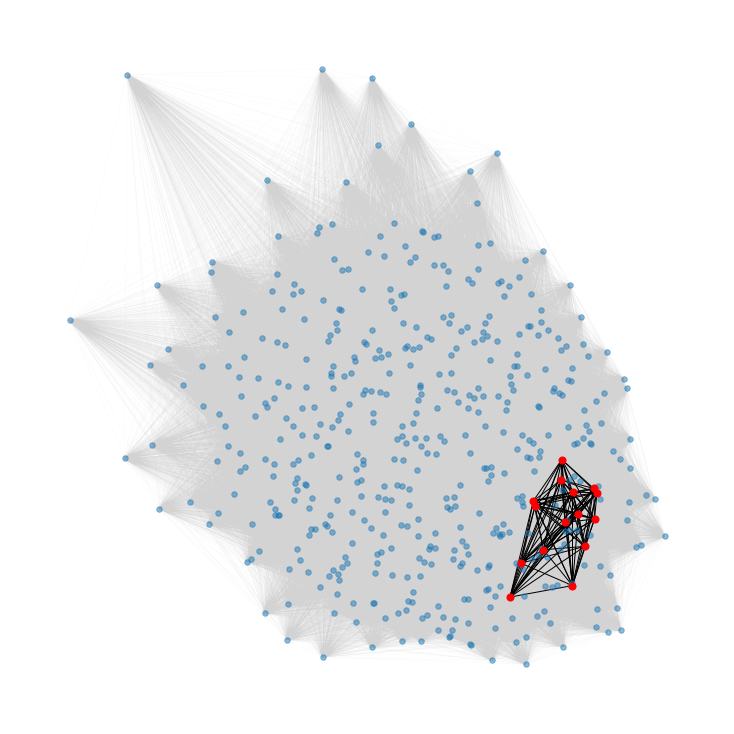

In [22]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=30, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=50)

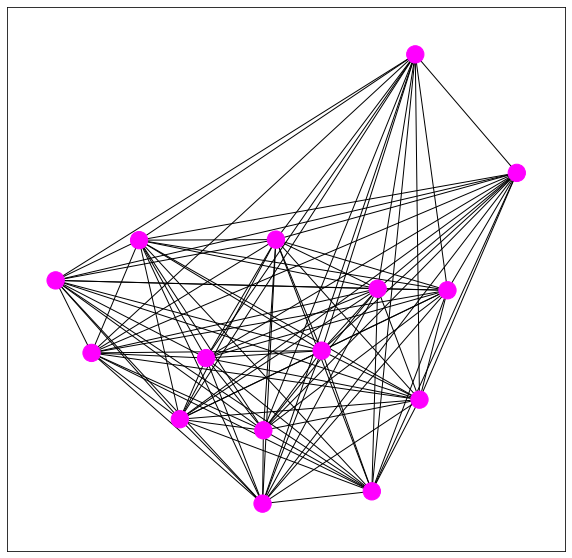

In [23]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

In [24]:
corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,0.7)
G = stock_corr_net(W_edge)

c_map = []
for node in G:
    c_map.append(sect_dict[node])   

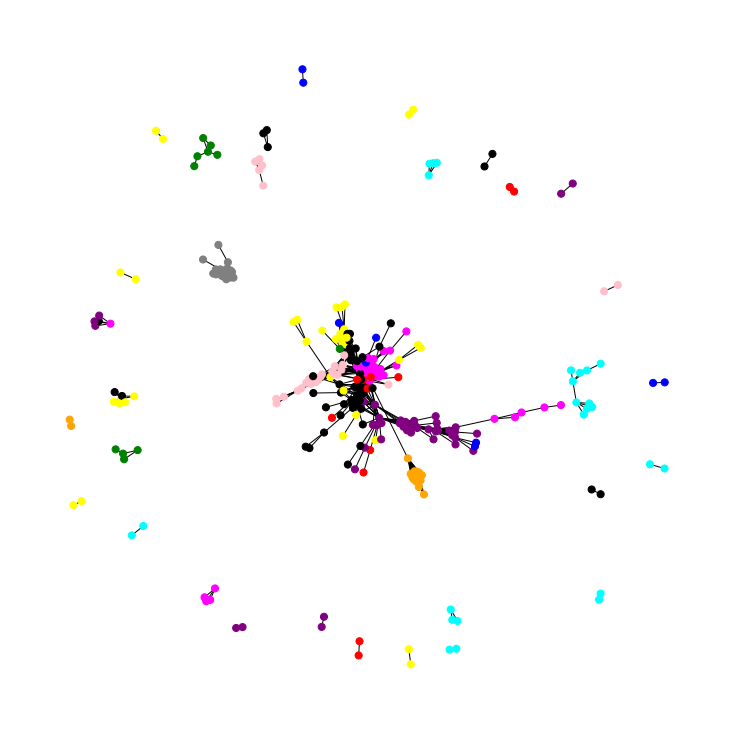

In [25]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 52686 rows, 331 columns and 105372 nonzeros
Model fingerprint: 0xab3b754b
Variable types: 0 continuous, 331 integer (331 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -2.0000000
Presolve removed 51487 rows and 0 columns
Presolve time: 0.30s
Presolved: 1199 rows, 331 columns, 46345 nonzeros
Variable types: 0 continuous, 331 integer (331 binary)

Root relaxation: objective -3.000000e+01, 59 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -30.0000000  -30.00000  0.00%     -    0s

Explored 1 nodes (59 si

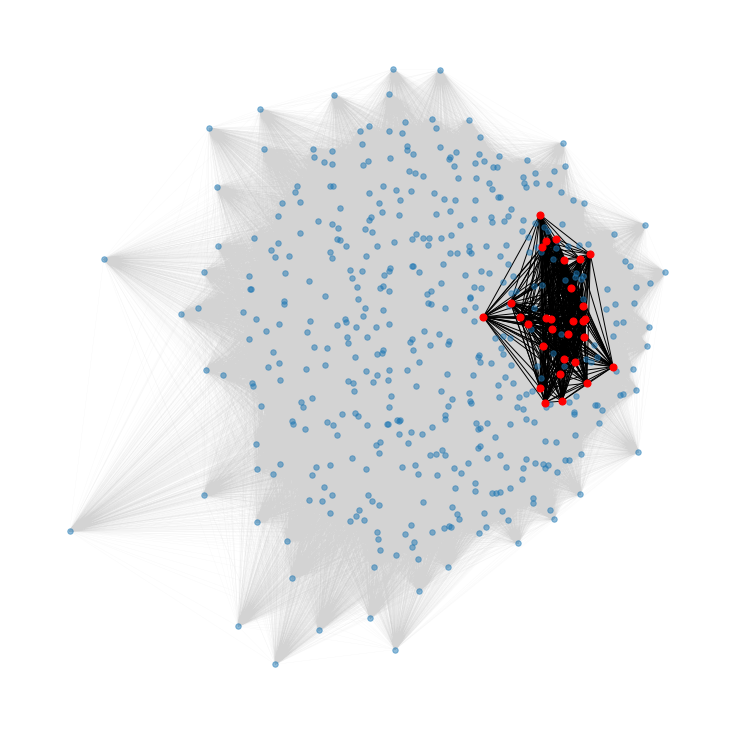

In [26]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=30, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=50)

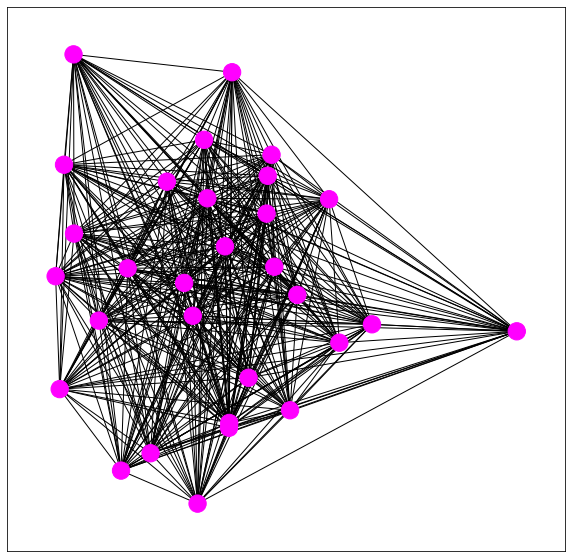

In [27]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

In [28]:
corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,0.6)
G = stock_corr_net(W_edge)

c_map = []
for node in G:
    c_map.append(sect_dict[node])   

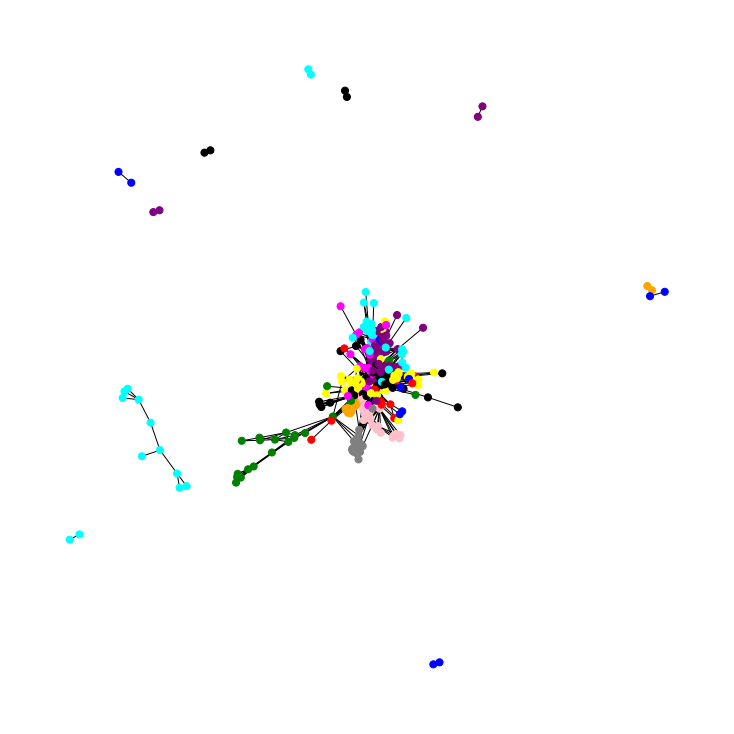

In [29]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 82840 rows, 426 columns and 165680 nonzeros
Model fingerprint: 0x297441a5
Variable types: 0 continuous, 426 integer (426 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -18.0000000
Presolve removed 80082 rows and 36 columns
Presolve time: 0.64s
Presolved: 2758 rows, 390 columns, 40200 nonzeros
Variable types: 0 continuous, 390 integer (390 binary)

Root relaxation: objective -4.800000e+01, 440 iterations, 0.05 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     -48.0000000  -48.00000  0.00%     -    0s

Explored 1 nodes (44

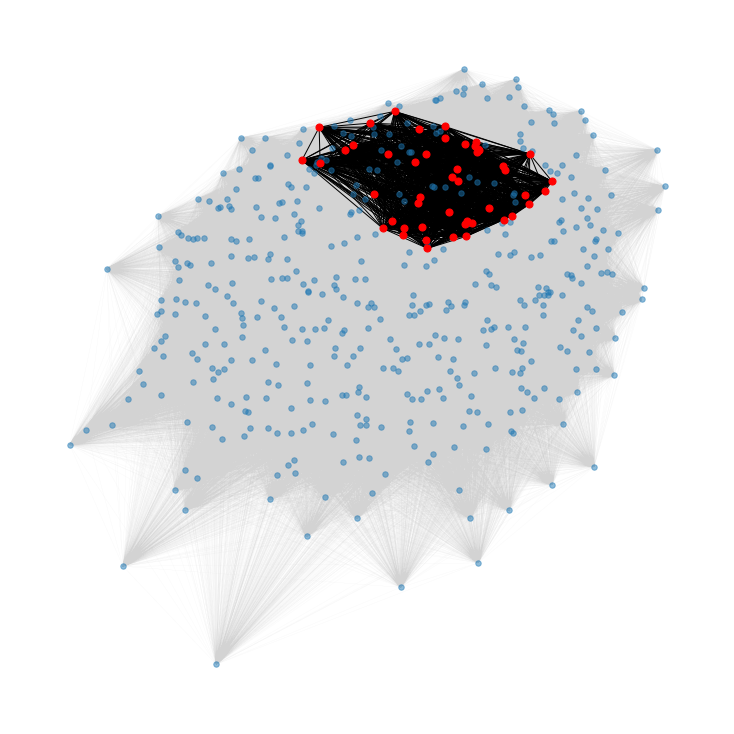

In [30]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=30, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=50)

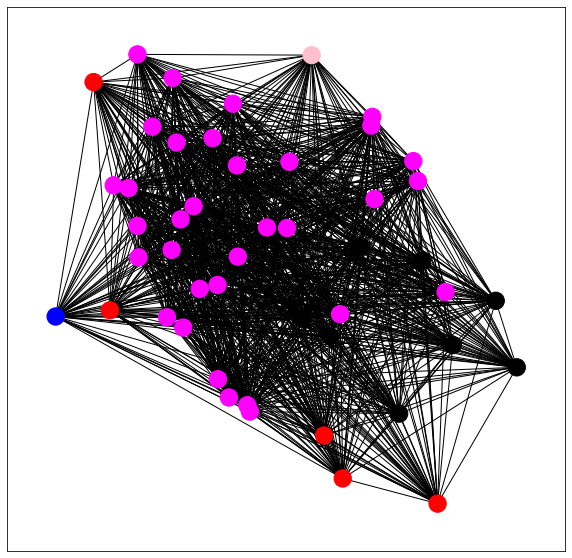

In [31]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

In [32]:
corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,0.25)
G = stock_corr_net(W_edge)

c_map = []
for node in G:
    c_map.append(sect_dict[node])   

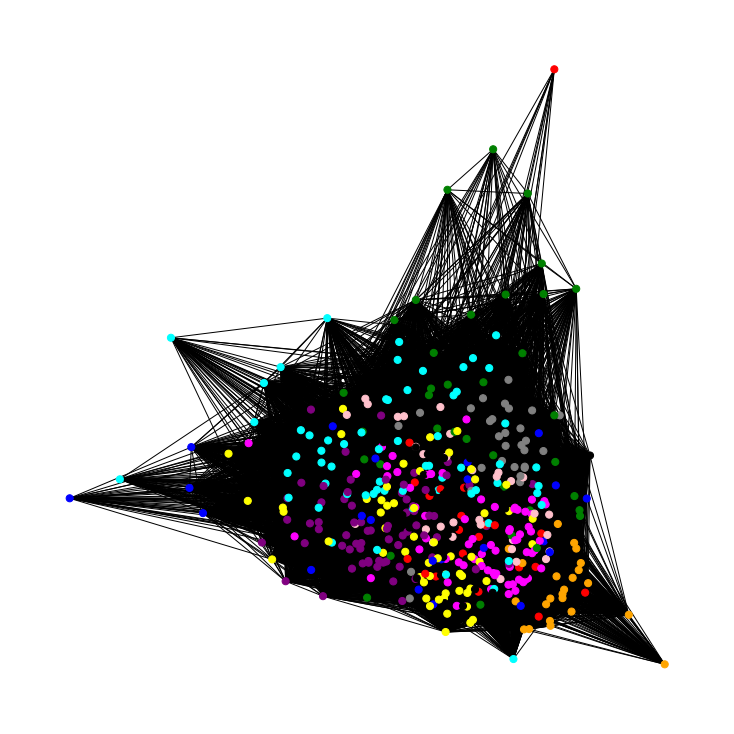

In [33]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 27743 rows, 493 columns and 55486 nonzeros
Model fingerprint: 0x80371ff0
Variable types: 0 continuous, 493 integer (493 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -262.0000000
Presolve removed 27661 rows and 453 columns
Presolve time: 0.28s
Presolved: 82 rows, 40 columns, 164 nonzeros
Found heuristic solution: objective -271.0000000
Variable types: 0 continuous, 40 integer (40 binary)

Root relaxation: objective -2.780000e+02, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    -278.0000000 -278.00000

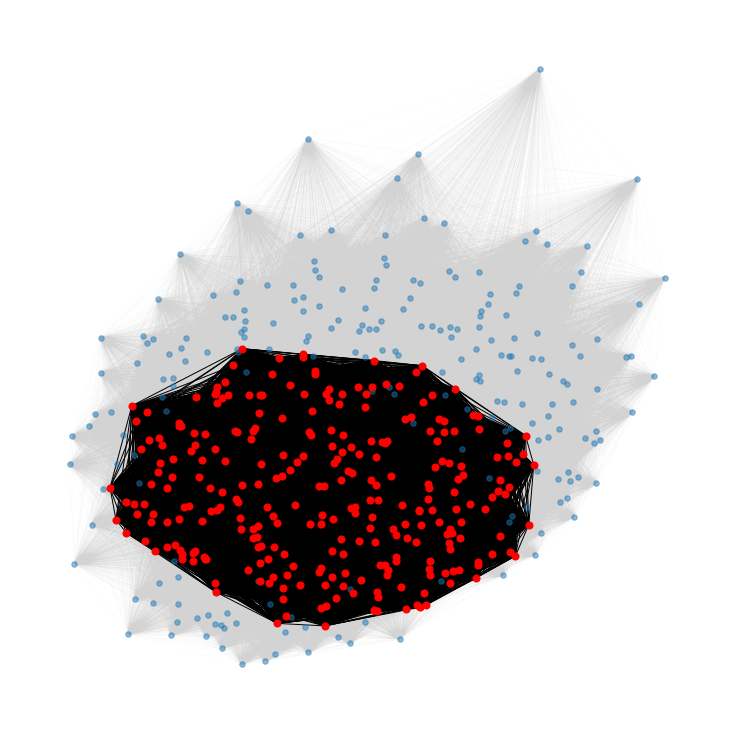

In [34]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=30, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=50)

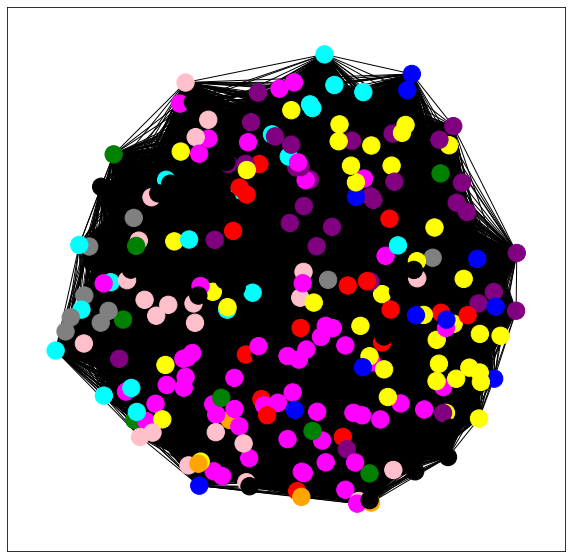

In [35]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

In [36]:
corr = corr_mat(F_data,'pearson')
W_edge = weight_matrix(corr,-0.2)
G = stock_corr_net(W_edge)

c_map = []
for node in G:
    c_map.append(sect_dict[node])   

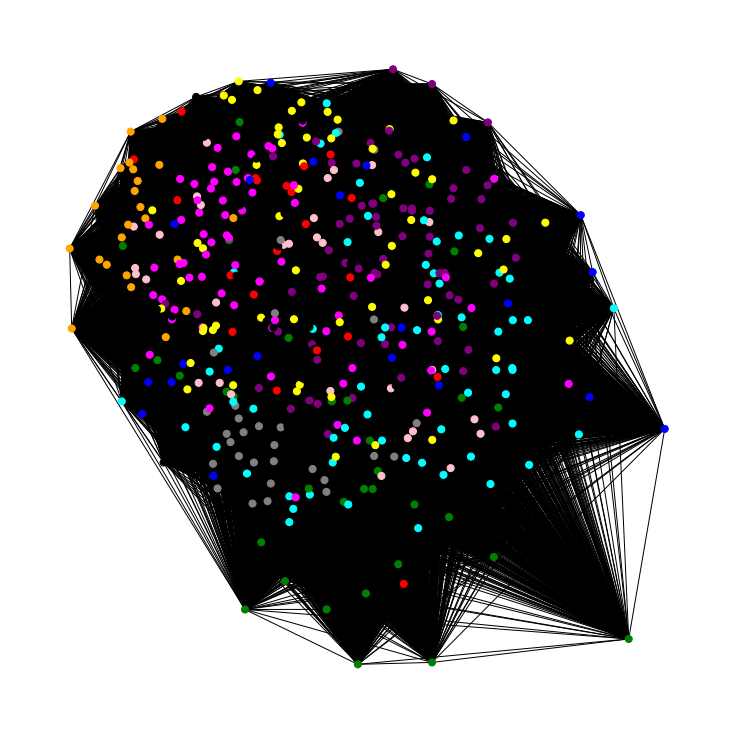

In [37]:
pos = nx.spring_layout(G)
nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 50, width = 1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 0 rows, 493 columns and 0 nonzeros
Model fingerprint: 0xa07b3c69
Variable types: 0 continuous, 493 integer (493 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -493.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: -493 
No other solutions better than -493

Optimal solution found (tolerance 1.00e-04)
Best objective -4.930000000000e+02, best bound -4.930000000000e+02, gap 0.0000%


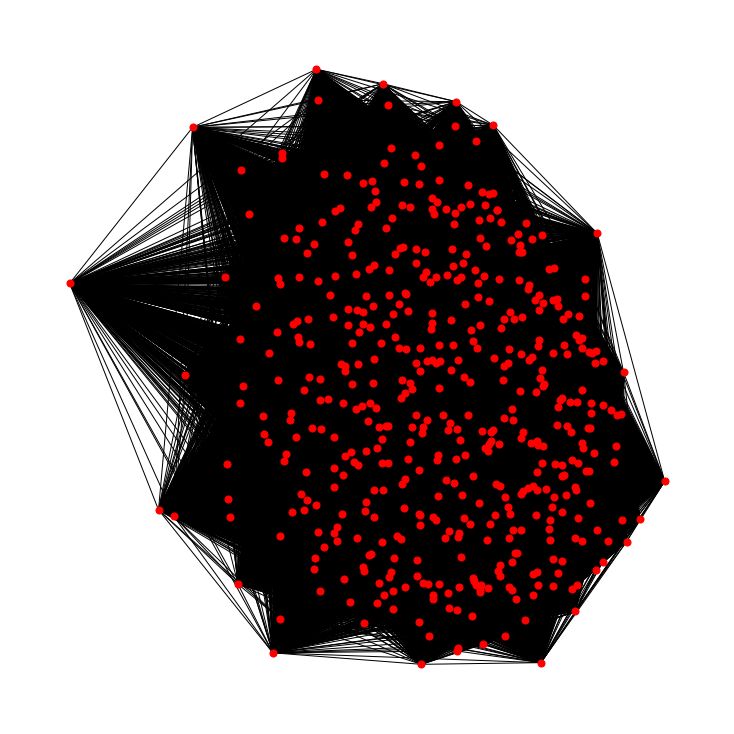

In [38]:
model=Model("max_clique")
x=model.addVars(G.nodes(), vtype=GRB.BINARY, obj=-1)

for (i,j) in combinations(G.nodes(),2):
    if (i,j) not in G.edges():
        model.addConstr(x[i]+x[j]<=1)
model.optimize()

clique_nodes_1=[i for i in G.nodes() if x[i].X==1]
clique_edges_1=[(i,j) for (i,j) in G.edges() if i in clique_nodes_1 and j in clique_nodes_1]

pos=nx.spring_layout(H)
nx.draw(H, pos, node_size=30, width=0.1, alpha=0.5, edge_color = 'lightgray')
nx.draw_networkx_edges(G, pos, edgelist=clique_edges_1, edge_color='black', width=1)
nx.draw_networkx_nodes(G, pos, nodelist=clique_nodes_1, node_color='r', node_size=50)

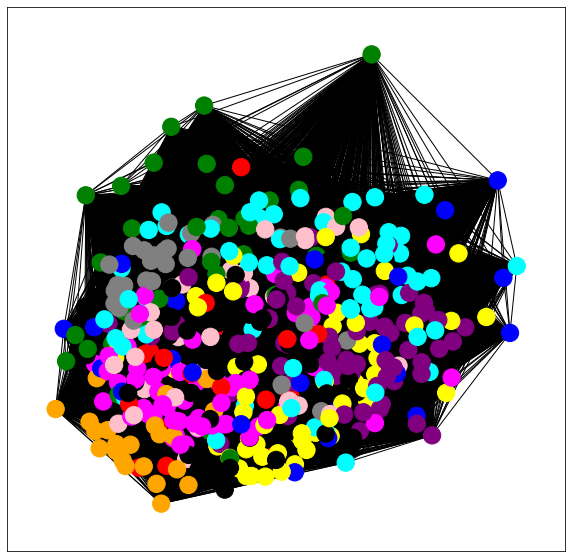

In [39]:
c_map = []
for node in clique_nodes_1:
    c_map.append(sect_dict[node])   
    
pos1 = nx.spring_layout(G)
# nx.draw(G,pos1, nodelist=clique_nodes_1, node_color=c_map, with_labels=False, node_size = 50, width = 1)
nx.draw_networkx_edges(G, pos1, edgelist=clique_edges_1, width=1)
nx.draw_networkx_nodes(G, pos1, nodelist=clique_nodes_1, node_color=c_map)

Minimum Spanning Tree

In [40]:
def distance_matrix(corr):
    dist = pd.DataFrame()
    dist = corr.copy()
    dist = np.sqrt(2*(1-corr))
    return dist

In [41]:
def stock_dist_net(edge_weights):
    G = nx.Graph()
    for i in list(edge_weights.index):
        for j in list(edge_weights.index):
            if j!=i:
                G.add_edge(i,j, weight=edge_weights[i][j])
    return G

Minimum Spanning Tree: Distance based network

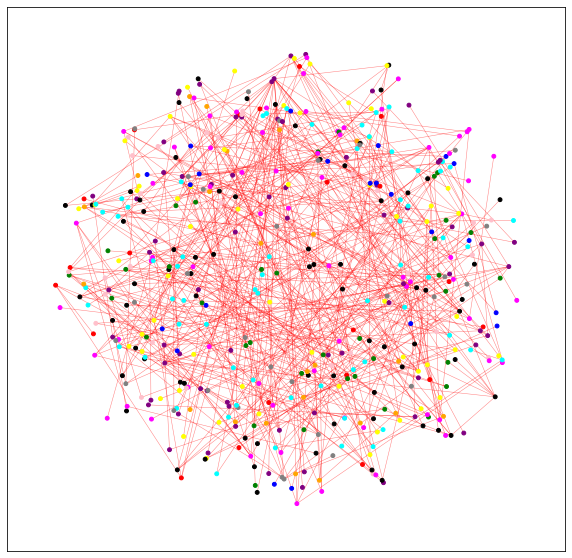

In [42]:
corr = corr_mat(F_data,'pearson')
W_edge = distance_matrix(corr)
G = stock_dist_net(W_edge)
c_map = []
for node in G:
    c_map.append(sect_dict[node])
pos = nx.spring_layout(G)
# nx.draw(G,pos, node_color=c_map, with_labels=False, node_size = 30, width = 0.05)
T=nx.minimum_spanning_tree(G)
ered=[(i,j) for (i,j) in T.edges()] # selecting the edges in the tree (so that we can edit them in the plot)
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(), node_color=c_map, node_size=15)
nx.draw_networkx_edges(G,pos,edgelist=ered, edge_color='r', width=0.5, alpha = 0.5)